In [64]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
#Make sure you update it before starting this notebook
import lucem_illud #pip install -U git+git://github.com/Computational-Content-Analysis-2018/lucem_illud.git

#All these packages need to be installed from pip

#This will be doing most of the work
import networkx as nx

import nltk #For POS tagging
import sklearn #For generating some matrices
import pandas #For DataFrames
import numpy as np #For arrays
import matplotlib.pyplot as plt #For plotting
import seaborn #Makes the plots look nice
import scipy #Some stats
from itertools import chain


import pickle #if you want to save layouts
import os

%matplotlib inline

## Data

I am going to be using a dataset that contains speeches given by different countries at the United Nations General Debate from 1974 - 2015. I will be using a subset of these speeches for analysis in this assignment.

In [106]:
senReleasesDF = pandas.read_csv('../DATA/un-general-debates.csv')
senReleasesDF = senReleasesDF.sort_values(by='year')[-100:]

In [107]:
senReleasesDF['tokenized_sents'] = senReleasesDF['text'].apply(lambda x: [nltk.word_tokenize(s) for s in nltk.sent_tokenize(x)])
senReleasesDF['normalized_sents'] = senReleasesDF['tokenized_sents'].apply(lambda x: [lucem_illud.normalizeTokens(s, stopwordLst = lucem_illud.stop_words_basic, stemmer = lucem_illud.stemmer_basic) for s in x])
senReleasesDF['tokenized_words'] = senReleasesDF['text'].apply(lambda x: nltk.word_tokenize(x))
senReleasesDF['normalized_words'] = senReleasesDF['tokenized_words'].apply(lambda x: [lucem_illud.normalizeTokens(x, stopwordLst = lucem_illud.stop_words_basic, stemmer = lucem_illud.stemmer_basic)])
senReleasesDF['normalized_words'] = list(chain.from_iterable(senReleasesDF['normalized_words'] ))

In [108]:
senReleasesDF[:3]

,session,year,country,text,tokenized_sents,normalized_sents,tokenized_words,normalized_words
5382,70,2015,SYR,I would like to congratulate Mr. Mogens Lykket...,"[[I, would, like, to, congratulate, Mr., Mogen...","[[would, like, congratul, mogen, lykketoft, el...","[I, would, like, to, congratulate, Mr., Mogens...","[would, like, congratul, mogen, lykketoft, ele..."
5381,70,2015,TUV,On behalf of the Government and the people of ...,"[[On, behalf, of, the, Government, and, the, p...","[[behalf, govern, peopl, tuvalu, inde, great, ...","[On, behalf, of, the, Government, and, the, pe...","[behalf, govern, peopl, tuvalu, inde, great, h..."
5390,70,2015,LIE,"It is an honour to be back in the Assembly, es...","[[It, is, an, honour, to, be, back, in, the, A...","[[honour, back, assembl, especi, liechtenstein...","[It, is, an, honour, to, be, back, in, the, As...","[honour, back, assembl, especi, liechtenstein,..."


Let's begin by looking at words that co-occur in the same sentences:

In [109]:
def wordCooccurrence(sentences, makeMatrix = False):
    words = set()
    for sent in sentences:
        words |= set(sent)
    wordLst = list(words)
    wordIndices = {w: i for i, w in enumerate(wordLst)}
    wordCoCounts = {}
    #consider a sparse matrix if memory becomes an issue
    coOcMat = np.zeros((len(wordIndices), len(wordIndices)))
    for sent in sentences:
        for i, word1 in enumerate(sent):
            word1Index = wordIndices[word1]
            for word2 in sent[i + 1:]:
                coOcMat[word1Index][wordIndices[word2]] += 1
    if makeMatrix:
        return coOcMat, wordLst
    else:
        coOcMat = coOcMat.T + coOcMat
        g = nx.convert_matrix.from_numpy_matrix(coOcMat)
        g = nx.relabel_nodes(g, {i : w for i, w in enumerate(wordLst)})
        return g

First, build a graph based on word cooccurences in the most recent 100 speeches.

In [110]:
g = wordCooccurrence(senReleasesDF['normalized_sents'].sum())

In [111]:
g1=g

Total number of vertices:

In [112]:
len(g.nodes())

6005

Total number of edges:

In [113]:
len(g.edges())

416190

A part of the adjacency matrix of cleaned word by speeches:

In [114]:
nx.to_numpy_matrix(g)[:5, :5]

matrix([[ 0.,  1.,  1.,  1.,  1.],
        [ 1.,  0.,  2.,  2.,  4.],
        [ 1.,  2.,  8., 16.,  1.],
        [ 1.,  2., 16.,  4.,  2.],
        [ 1.,  4.,  1.,  2.,  2.]])

/Users/arvindilamaran/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:522: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  
/Users/arvindilamaran/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:543: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  raise ImportError("Matplotlib required for draw()")
/Users/arvindilamaran/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:724: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  


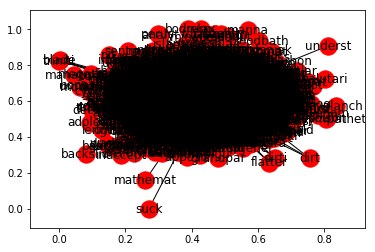

In [115]:
nx.draw_networkx(g)

This graph is too crowded for any useful analysis. Let us make it more tractable.

Alternatively, we can build graphs starting with a two-mode network. Let's again use the document-word frequency matrix that we used in week 3.

In [116]:
def tokenize(text):
    tokenlist = nltk.word_tokenize(text)
    normalized = lucem_illud.normalizeTokens(tokenlist, stopwordLst = lucem_illud.stop_words_basic, stemmer = lucem_illud.stemmer_basic)
    return normalized

In [117]:
senVectorizer = sklearn.feature_extraction.text.CountVectorizer(tokenizer = tokenize)
senVects_incidence = senVectorizer.fit_transform(senReleasesDF['text'])

In [118]:
senVects_incidence.shape

(100, 6005)

We need to turn the incidence matrix into a network. Note the use of bipartite as an attribute--this is how you need to tell networkx the graph is bipartite:

In [119]:
g_2mode = nx.Graph()

#define all the nodes
g_2mode.add_nodes_from((senVectorizer.get_feature_names()[i] for i in range(senVects_incidence.shape[1])), bipartite = 'word')
g_2mode.add_nodes_from(range(senVects_incidence.shape[0]), bipartite = 'doc')

#add all the edges
g_2mode.add_edges_from(((d, senVectorizer.get_feature_names()[w], {'weight' : senVects_incidence[d, w]}) for d, w in zip(*senVects_incidence.nonzero())))

In [121]:
print(nx.info(g_2mode))

Name: 
Type: Graph
Number of nodes: 6105
Number of edges: 54973
Average degree:  18.0092


A very popular layout algorithm for visualizing graphs is the Fruchterman-Reingold Algorithm (or spring layout), which uses a physical metaphor for lay-out. Nodes repel one another, and edges draw connected elements together like springs. The algorithm attempts to minimize the energy in such a system. For a large graph, however, the algorithm is computational demanding. 

Let's plot the bipartite network with a quick spring layout:

/Users/arvindilamaran/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:522: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not cb.is_string_like(edge_color) \
/Users/arvindilamaran/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:543: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if cb.is_string_like(edge_color) or len(edge_color) == 1:
/Users/arvindilamaran/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:724: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not cb.is_string_like(label):


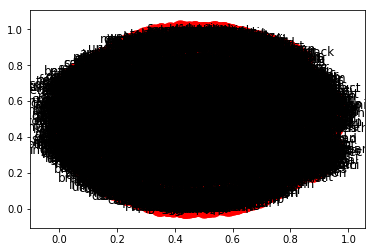

In [35]:
nx.draw_networkx(g_2mode)

With no filtering, this will not bring insight (see below). If we want even faster computation and tunable visualizations, check out [Pajek](http://mrvar.fdv.uni-lj.si/pajek/) or [gephi](https://gephi.org/).

A two-mode network can be easily transformed into two one-mode network, enabling words to be connected to other words via the number of documents that share them, or documents to be connected to other documents via the words they share:

In [122]:
def contractNetwork(g, targetType):
    g_mono = nx.Graph()
    g_mono.add_nodes_from(((n, d) for n, d in g_2mode.nodes(data = True) if d['bipartite'] == targetType))
    
    for n_outside in (n for n, d in g_2mode.nodes(data = True) if d['bipartite'] != targetType):
        neighbors = list((n for n in g.neighbors(n_outside) if g.node[n]['bipartite'] == targetType))
        for i, n1 in enumerate(neighbors):
            for n2 in neighbors[i+1:]:
                try:
                    g_mono.edge[n1, n2]['weight'] += 1
                except KeyError:
                    g_mono.add_edge(n1, n2, weight = 1)
    return g_mono

In [123]:
gDoc = contractNetwork(g_2mode,'doc')

Let's first take a look at the document-to-document network:

In [124]:
print(nx.info(gDoc))

Name: 
Type: Graph
Number of nodes: 100
Number of edges: 4950
Average degree:  99.0000


Let's construct a visualization. It is not surprising that almost every document is connected to every other. We can use edge weight to distinguish document distance (modeled as attraction):

/Users/arvindilamaran/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:522: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  
/Users/arvindilamaran/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:543: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  raise ImportError("Matplotlib required for draw()")
/Users/arvindilamaran/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:724: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  


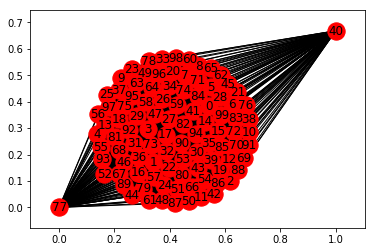

In [125]:
layout = nx.spring_layout(gDoc, k = 1/3, weight='weight', iterations= 100)
nx.draw_networkx(gDoc, pos = layout, labels = {n:n for n in gDoc.nodes()}) #Getting labels is a bit annoying

Lets draw the graph with high and low weight edges distinguished:

/Users/arvindilamaran/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:522: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  
/Users/arvindilamaran/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:543: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  raise ImportError("Matplotlib required for draw()")
/Users/arvindilamaran/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:724: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  


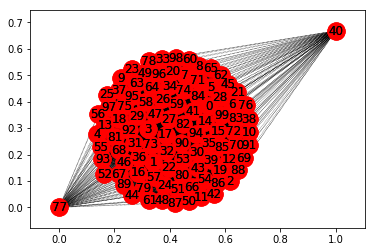

In [126]:
wMedian = np.median([d['weight'] for n1, n2, d in gDoc.edges(data = True)])
edgesHigh = [(n1, n2) for n1, n2, d in gDoc.edges(data = True) if d['weight'] > wMedian]
edgesLow = [(n1, n2) for n1, n2, d in gDoc.edges(data = True) if d['weight'] <= wMedian]
nx.draw_networkx(gDoc, pos = layout, labels = {n:n for n in gDoc.nodes()}, edgelist = edgesLow, style='dotted', width=.5)
nx.draw_networkx(gDoc, pos = layout, nodelist=None, edgelist = edgesHigh, width=2)

Now we can see why 77 and 40 are on the outside, while 17 and 27 are at the center. We can look at them:

In [130]:
print(len(senReleasesDF.iloc[77]['text']),"words:","\n")
print(len(senReleasesDF.iloc[1]['text']),"words:","\n")
print(len(senReleasesDF.iloc[17]['text']),"words:","\n")

11069 words: 

13862 words: 

14220 words: 



The documents with lesser words are outside and more words are placed closed to the center in this network

Now let's turn it around and look at the word-to-word network by documents. 

In [131]:
gWord = contractNetwork(g_2mode, 'word')
print(nx.info(gWord))

Name: 
Type: Graph
Number of nodes: 6005
Number of edges: 5010776
Average degree: 1668.8679


First, let's reduce the number of words to a manageable size.

In [ ]:
nx.draw_networkx(gWord)

In [132]:
wMean = np.mean([d['weight'] for n1, n2, d in gWord.edges(data = True)])
wMean

1.0

We are going to return to the sentence cooccurence graph, as it suggests many more meaningful (more local) associations. But without filtering, it is too large. Let's first drop all the edges with weight below 100, then drop all the isolates:

In [133]:
g = wordCooccurrence(senReleasesDF['normalized_sents'].sum())
g.remove_edges_from([(n1, n2) for n1, n2, d in g.edges(data = True) if d['weight'] <= 100])
g.remove_nodes_from(list(nx.isolates(g))) #since we are changing the graph list() evaluates the isolates first
giant = max(nx.connected_component_subgraphs(g), key=len) # keep just the giant connected component
print(nx.info(giant))

Name: ()
Type: Graph
Number of nodes: 37
Number of edges: 96
Average degree:   5.1892


In [134]:
gtest = giant
print(nx.info(gtest))

Name: ()
Type: Graph
Number of nodes: 37
Number of edges: 96
Average degree:   5.1892


A bit smaller now, Now, let's visualize it: 

/Users/arvindilamaran/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  draw_networkx(G, pos=pos, ax=ax, **kwds)
/Users/arvindilamaran/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:522: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  
/Users/arvindilamaran/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:543: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  raise ImportError("Matplotlib required for draw()")
/Users/arvindilamaran/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:724: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  
/Users/arvindilamaran/anaconda3/lib/python3.6/si

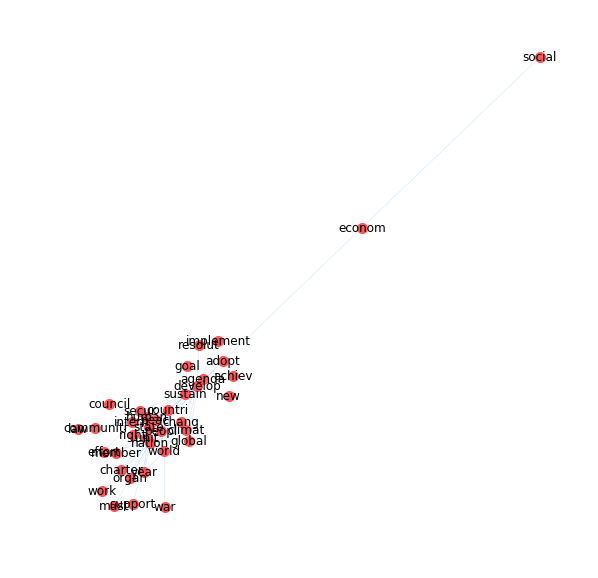

In [135]:
layout = nx.spring_layout(giant, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=.2, 
        alpha = .9, 
        node_size = 100,
        node_color = "xkcd:light red",
        edge_color='xkcd:sky blue') #Getting labels is a bit annoying

Since this is the speech at United Nations, we can expect certain set of words to be used very frequently, leading to an overestimation of word frequency relevant for analysis. We address this issue below.

We can also remove those words that show up in many documents...those with many connections (note that this has a similar effect to selecting those with a high tf.idf score):

In [2]:
giant.remove_nodes_from([n for n in giant.node if len(set(giant.neighbors(n))) >= 2000]) 
giant.remove_nodes_from(list(nx.isolates(giant)))
#print(nx.info(giant))

/Users/arvindilamaran/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  draw_networkx(G, pos=pos, ax=ax, **kwds)
/Users/arvindilamaran/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:522: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  
/Users/arvindilamaran/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:543: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  raise ImportError("Matplotlib required for draw()")
/Users/arvindilamaran/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:724: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  
/Users/arvindilamaran/anaconda3/lib/python3.6/si

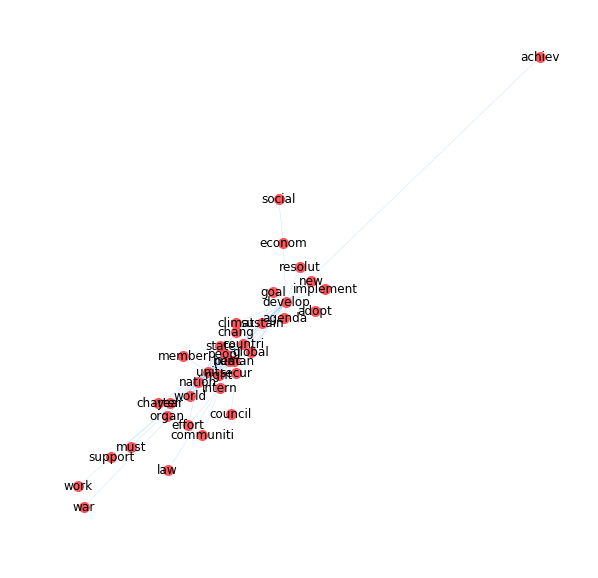

In [137]:
layout = nx.spring_layout(giant, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=.2, 
        alpha = .9, 
        node_size = 100,
        node_color = "xkcd:light red",
        edge_color='xkcd:sky blue') #Getting labels is a bit annoying

Key words like `climate`, `econom` and others have moved positions in the network after pruning words that occur very frequently in the text. But we also know that words like `effort`, `community`, `support`, also occur frequently. But removing them might make it difficult to analyze certain contextual questions in the future.

We can continue to trim globally to investigate the structure of words at alternative slices of network density. 

Moreover, we can find cliques, or completely connected sets of nodes. 

In [138]:
print(', '.join(max(nx.clique.find_cliques(giant), key = lambda x: len(x))))

right, unit, nation, peac, secur, intern


Now lets look at a subgraph of the network, those nodes that are within 1 or 2 network steps of 'econom'. 

In [140]:
americanNeighbors = giant.neighbors('secur')
g_american = giant.subgraph(americanNeighbors)
print(nx.info(g_american))

Name: ()
Type: Graph
Number of nodes: 9
Number of edges: 35
Average degree:   7.7778


/Users/arvindilamaran/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  draw_networkx(G, pos=pos, ax=ax, **kwds)
/Users/arvindilamaran/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:522: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  
/Users/arvindilamaran/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:543: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  raise ImportError("Matplotlib required for draw()")
/Users/arvindilamaran/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:724: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  
/Users/arvindilamaran/anaconda3/lib/python3.6/si

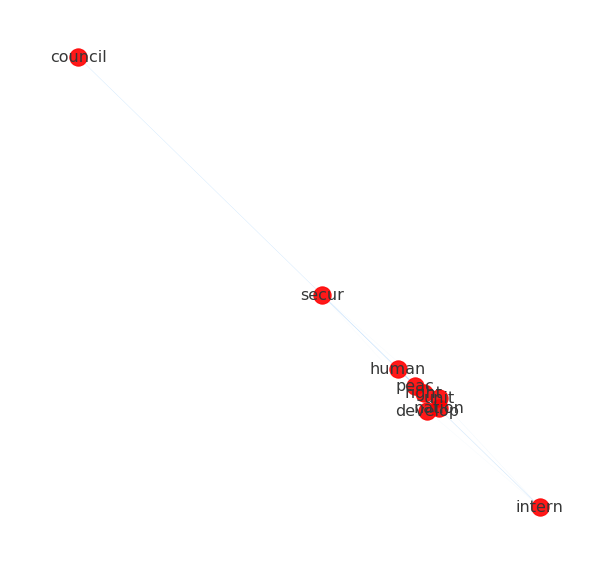

In [141]:
layout_amer = nx.spring_layout(g_american, weight='weight', iterations= 100, k = .3)
fig, ax = plt.subplots(figsize = (10,10))
maxWeight = max((d['weight'] for n1, n2, d in g_american.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in g_american.edges(data = True)))
nx.draw(g_american, ax = ax, pos = layout_amer, labels = {n:n for n in g_american.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in g_american.edges(data = True)], 
        alpha = .9, 
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:sky blue',
        cmap = plt.get_cmap('plasma')) 

The neighbors of the word `security` seems to be humanity, peace, development, unity. But it is interesting to note that the security council is linked to other major agendas of UN through the medium of security measures. Is that the story here? Looking at an ego-centric network of `security` might be of use here. 

In [143]:
#print(', '.join(max(nx.clique.find_cliques(gWord), key = lambda x: len(x))))

Let us look at the subgraph of neighbors of `security`

In [152]:
g_american2 = giant.subgraph(americanNeighborsPlus1)
print(nx.info(g_american2))

Name: ()
Type: Graph
Number of nodes: 36
Number of edges: 84
Average degree:   4.6667


/Users/arvindilamaran/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  draw_networkx(G, pos=pos, ax=ax, **kwds)
/Users/arvindilamaran/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:522: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  
/Users/arvindilamaran/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:543: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  raise ImportError("Matplotlib required for draw()")
/Users/arvindilamaran/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:724: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  
/Users/arvindilamaran/anaconda3/lib/python3.6/si

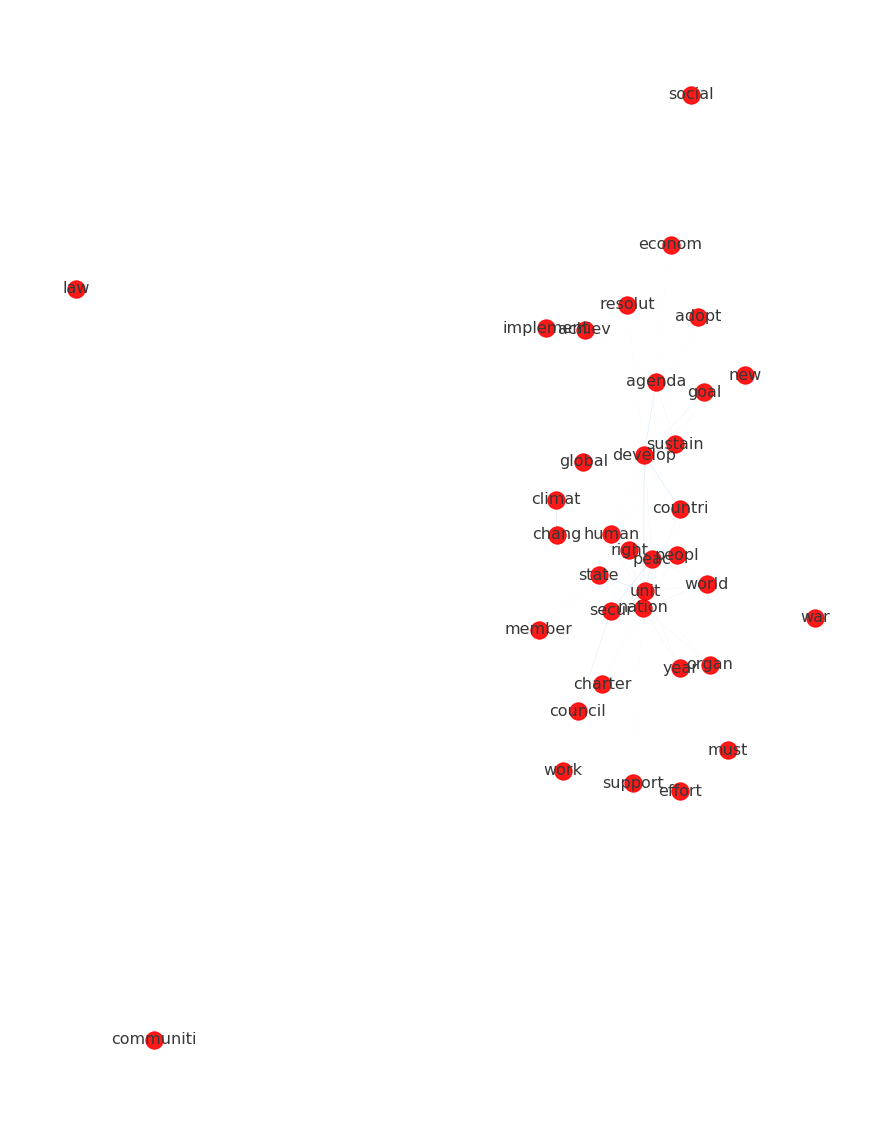

In [155]:
layout_amer = nx.spring_layout(g_american2, weight='weight', iterations= 100, k = .3)
fig, ax = plt.subplots(figsize = (15,20))
centralities_amer = nx.eigenvector_centrality(g_american2)
maxC = max(centralities_amer.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in g_american2.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in g_american2.edges(data = True)))
nx.draw(g_american2, ax = ax, pos = layout_amer, labels = {n:n for n in g_american2.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in g_american2.edges(data = True)], 
        alpha = .9, 
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:sky blue',
        cmap = plt.get_cmap('plasma')) 

Development seems to the central theme of the speeches with reference to community-based development being scarce given how disconnected `communiti` is from `develop`. It is interesting to note that `development` and `climate`(reference to climate-change) are not directly connected. This scenario exists despite the fact the speeches chosen from analysis were in the vicinity of 2015.

# Network Statistics
We can often gain more insight into our semantic network through statistics that describe the positions of words within it.

We begin with measures of centrality. The concept of centrality is that some nodes (words or documents) are more *central* to the network than others. The most straightforward is the notion of degree centrality: those nodes that have the highest number of connections are the most central. Here our measure normalizes the number of connections by those with the most connections.

In [156]:
dcentralities = nx.degree_centrality(giant)

In [160]:
dcentralities['climat']

0.08333333333333333

In [161]:
max(dcentralities.items(), key = lambda x : x[1])

('develop', 0.6666666666666666)

We can color and size the nodes by betweenness centrality, it's much faster to redraw since we aren't redoing the layout.

/Users/arvindilamaran/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  draw_networkx(G, pos=pos, ax=ax, **kwds)
/Users/arvindilamaran/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:522: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  
/Users/arvindilamaran/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:543: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  raise ImportError("Matplotlib required for draw()")
/Users/arvindilamaran/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:724: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  
/Users/arvindilamaran/anaconda3/lib/python3.6/si

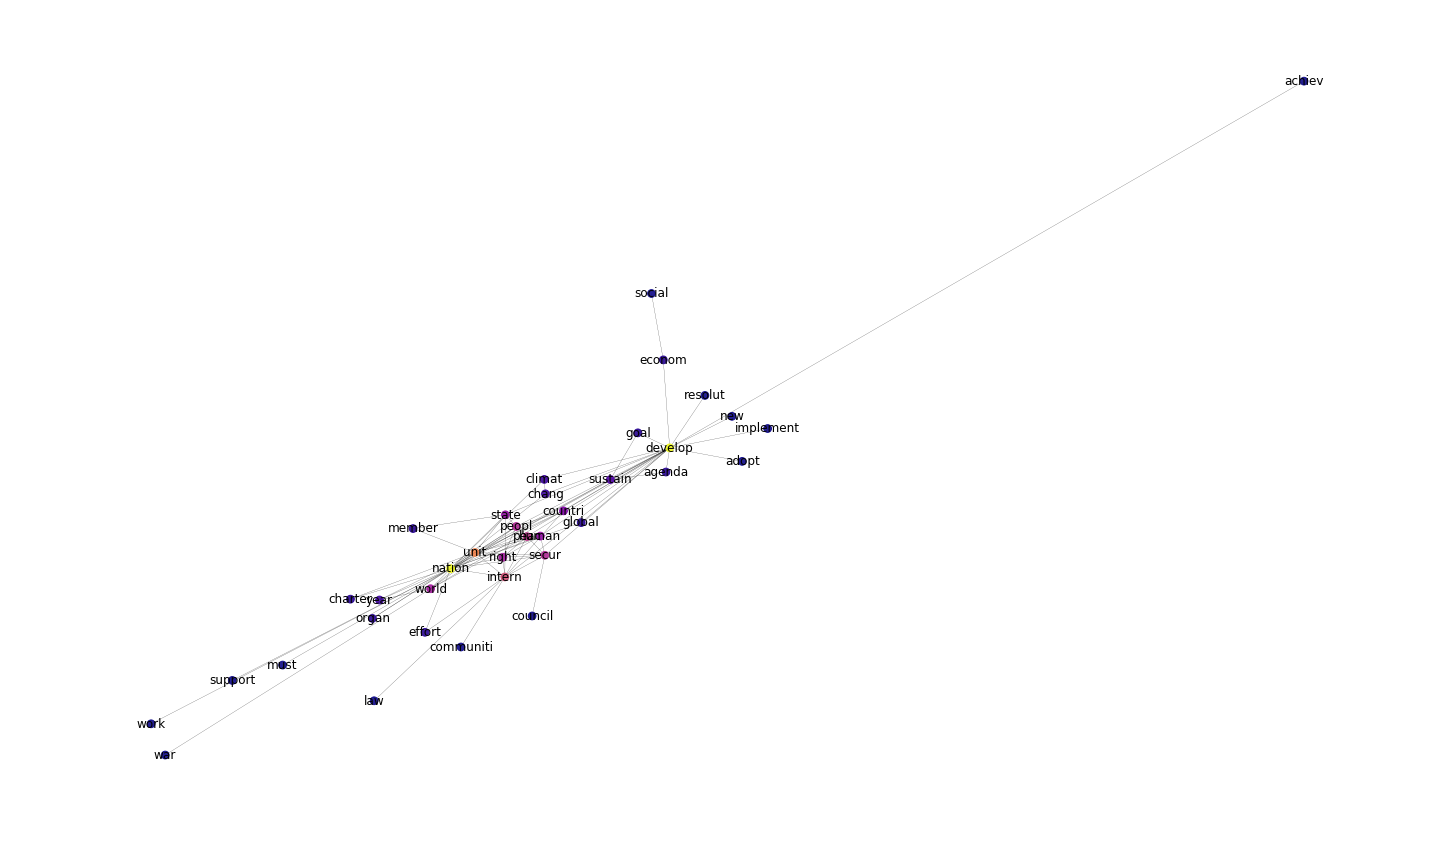

In [167]:
fig, ax = plt.subplots(figsize = (25,15))
maxC = max(dcentralities.items(), key = lambda x : x[1])[1]
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=.2, 
        alpha = .9, 
        node_size = 60,
        node_color = [dcentralities[n] / maxC for n in giant.nodes()],
        cmap = plt.get_cmap('plasma')) 

Another way to visualize the graph involes the use of size to represent degree centrality and edge weight:

/Users/arvindilamaran/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  draw_networkx(G, pos=pos, ax=ax, **kwds)
/Users/arvindilamaran/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:522: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  
/Users/arvindilamaran/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:543: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  raise ImportError("Matplotlib required for draw()")
/Users/arvindilamaran/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:724: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  
/Users/arvindilamaran/anaconda3/lib/python3.6/si

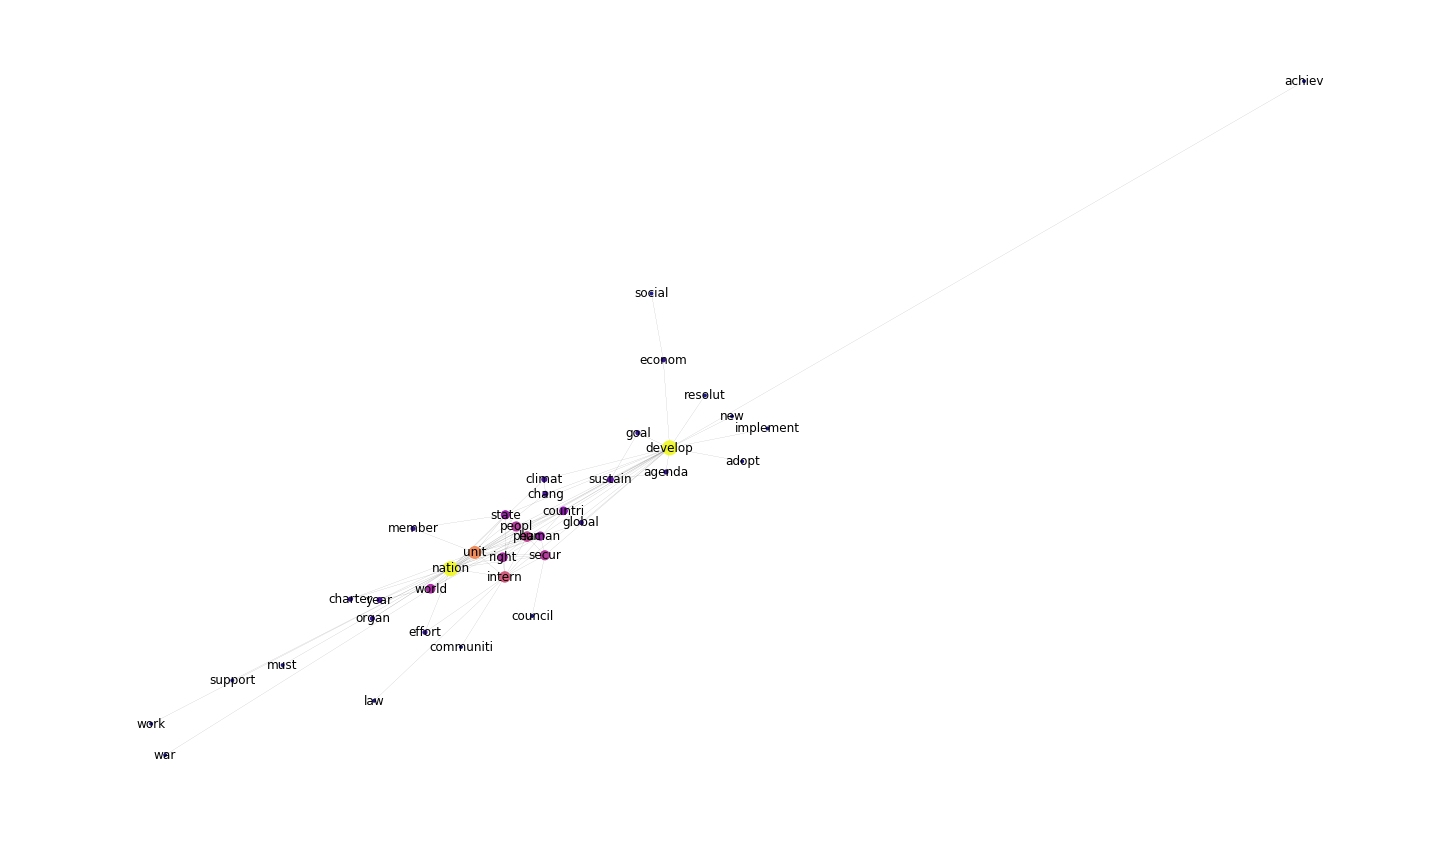

In [169]:
fig, ax = plt.subplots(figsize = (25,15))
maxC = max(dcentralities.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in giant.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in giant.edges(data = True)))
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in gWord.edges(data = True)], 
        alpha = .9, 
        node_color = [dcentralities[n] / maxC for n in giant.nodes()],
        node_size = [dcentralities[n] / maxC * 200 for n in giant.nodes()],
        cmap = plt.get_cmap('plasma')) 

The distrubution of degree centrality is:

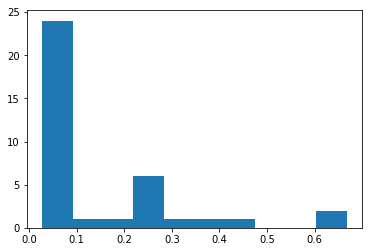

In [170]:
plt.hist(list(dcentralities.values()))
plt.show()

What are the top and bottom ten words in terms of degree?

In [171]:
sorted(dcentralities.items(), key = lambda x: x[1], reverse = True)[:10]

[('develop', 0.6666666666666666),
 ('nation', 0.6666666666666666),
 ('unit', 0.4722222222222222),
 ('intern', 0.3611111111111111),
 ('peac', 0.3055555555555555),
 ('secur', 0.2777777777777778),
 ('peopl', 0.2777777777777778),
 ('world', 0.25),
 ('right', 0.25),
 ('human', 0.2222222222222222)]

In [172]:
sorted(dcentralities.items(), key = lambda x: x[1], reverse = True)[-10:]

[('war', 0.027777777777777776),
 ('law', 0.027777777777777776),
 ('support', 0.027777777777777776),
 ('council', 0.027777777777777776),
 ('must', 0.027777777777777776),
 ('implement', 0.027777777777777776),
 ('new', 0.027777777777777776),
 ('resolut', 0.027777777777777776),
 ('adopt', 0.027777777777777776),
 ('communiti', 0.027777777777777776)]

Consider another very different measure, which is *betweenness* centrality. Betweenness centrality distinguishes nodes that require the most shortest pathways between all other nodes in the network. Semantically, words with a high betweenness centrality may link distinctive domains, rather than being "central" to any one. In other words, high *betweenness centrality* nodes may not have the highest *degree centrality*.

In [173]:
centralities = nx.betweenness.betweenness_centrality(giant)

In [174]:
max(centralities.items(), key = lambda x : x[1])

('develop', 0.48737339380196526)

We can color and size the nodes by betweenness centrality:

/Users/arvindilamaran/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  draw_networkx(G, pos=pos, ax=ax, **kwds)
/Users/arvindilamaran/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:522: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  
/Users/arvindilamaran/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:543: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  raise ImportError("Matplotlib required for draw()")
/Users/arvindilamaran/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:724: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  
/Users/arvindilamaran/anaconda3/lib/python3.6/si

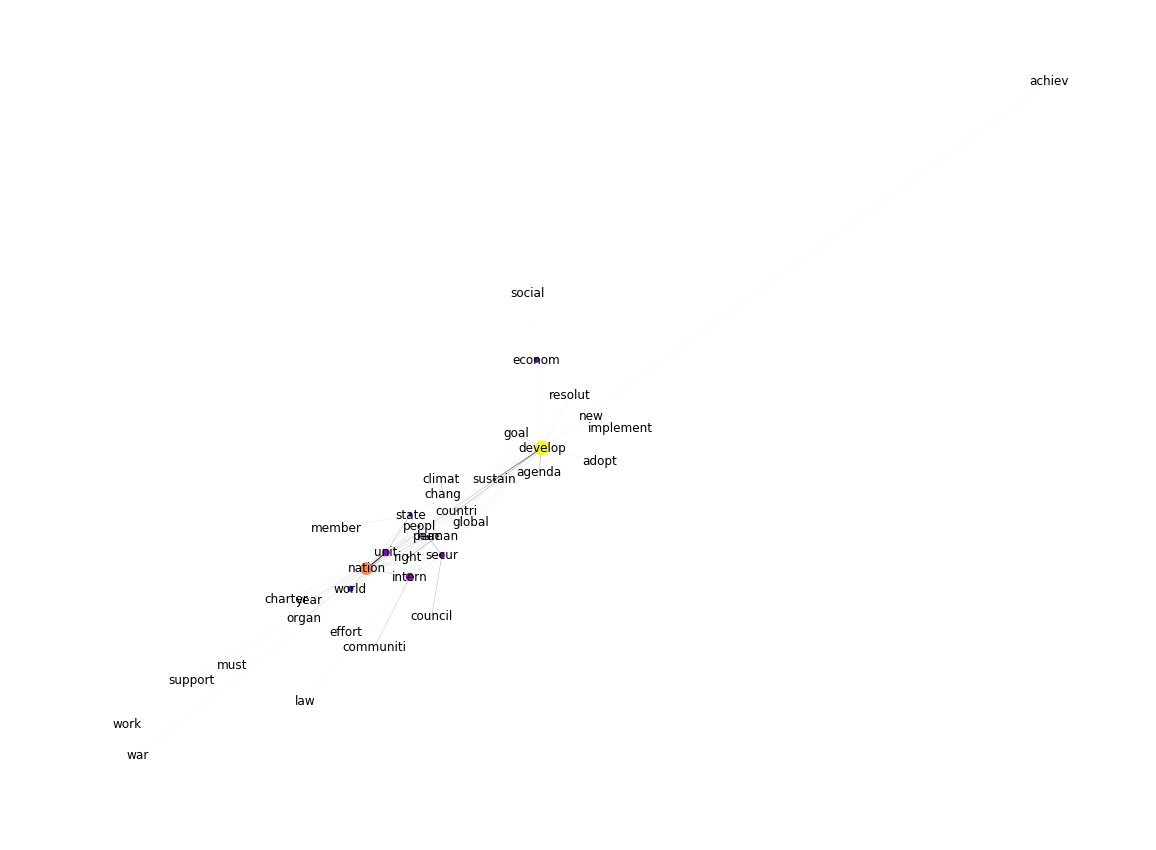

In [178]:
fig, ax = plt.subplots(figsize = (20,15))
maxC = max(centralities.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in giant.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in giant.edges(data = True)))
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in giant.edges(data = True)], 
        alpha = .9, 
        node_color = [centralities[n] / maxC for n in giant.nodes()],
        node_size = [centralities[n] / maxC * 200 for n in giant.nodes()],
        cmap = plt.get_cmap('plasma')) 

The distrubution of betweenness centrality is:

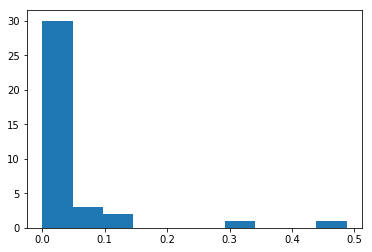

In [179]:
plt.hist(list(centralities.values()))
plt.show()

This is an exponential distrubution, but you might need to add more nodes to see it clearly.

What are the top ten words in terms of betweenness?

In [180]:
sorted(dcentralities.items(), key = lambda x: x[1], reverse = True)[:10]

[('develop', 0.6666666666666666),
 ('nation', 0.6666666666666666),
 ('unit', 0.4722222222222222),
 ('intern', 0.3611111111111111),
 ('peac', 0.3055555555555555),
 ('secur', 0.2777777777777778),
 ('peopl', 0.2777777777777778),
 ('world', 0.25),
 ('right', 0.25),
 ('human', 0.2222222222222222)]

The important terms in the broader network seem to be `develop, nation, unit(y,ed), intern(ational), peac(e), secur(ity), peopl(e), world, right(s), human(ity,kind)`

What are words lower down?

We can also look at closeness centrality, or the average Euclidean or path distance between a node and all others in the network. A node with the highest closeness centrality is most likely to send a signal with the most coverage to the rest of the network.

In [181]:
centralities = nx.closeness_centrality(giant)

/Users/arvindilamaran/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  draw_networkx(G, pos=pos, ax=ax, **kwds)
/Users/arvindilamaran/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:522: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  
/Users/arvindilamaran/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:543: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  raise ImportError("Matplotlib required for draw()")
/Users/arvindilamaran/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:724: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  
/Users/arvindilamaran/anaconda3/lib/python3.6/si

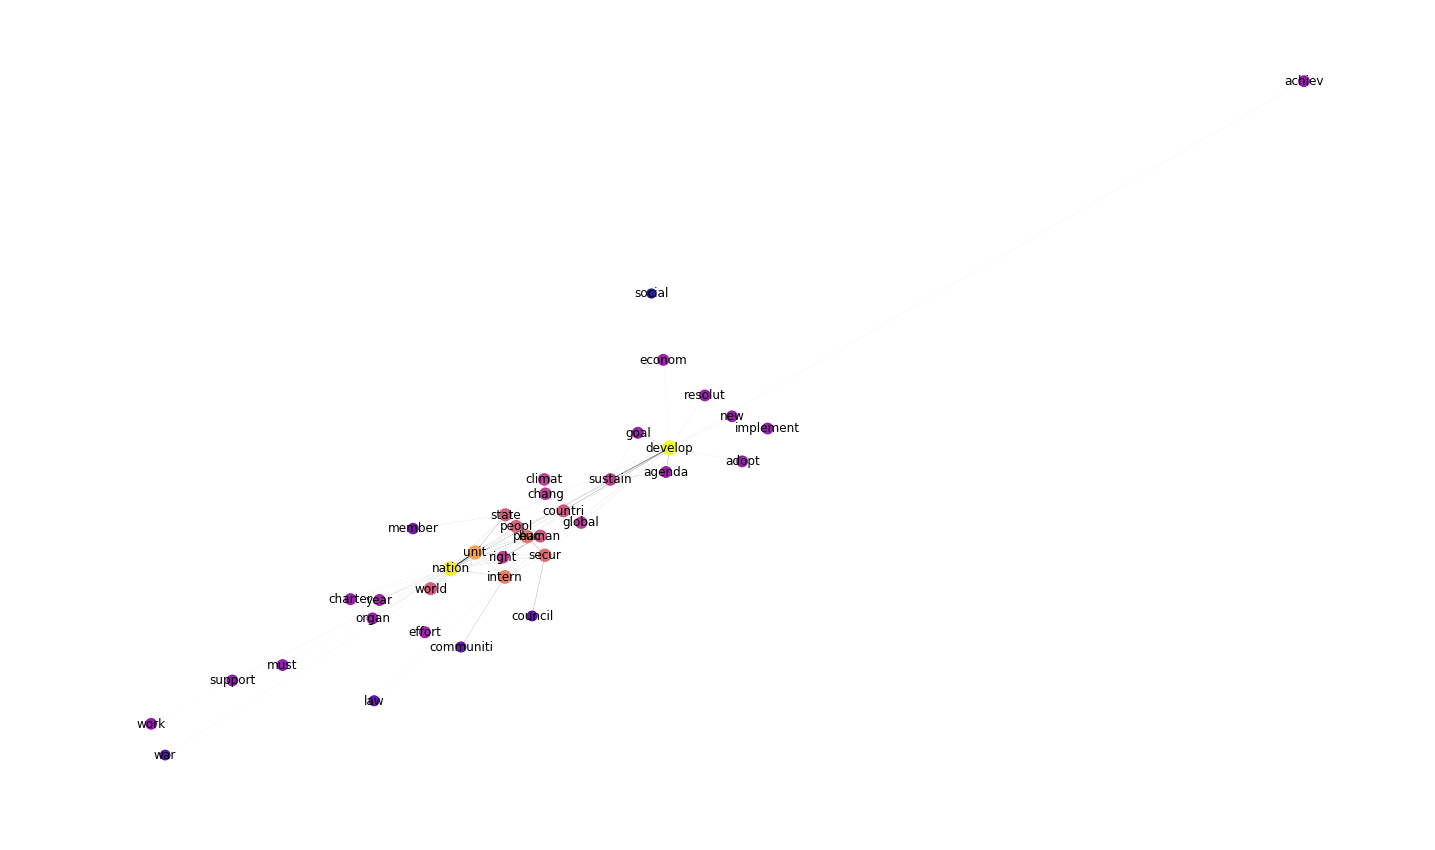

In [183]:
fig, ax = plt.subplots(figsize = (25,15))
maxC = max(centralities.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in giant.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in giant.edges(data = True)))
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in giant.edges(data = True)], 
        alpha = .9, 
        node_color = [centralities[n] / maxC for n in giant.nodes()],
        node_size = [centralities[n] / maxC * 200 for n in giant.nodes()],
        cmap = plt.get_cmap('plasma')) 

Top and bottom:

In [185]:
sorted(centralities.items(), key = lambda x: x[1], reverse = True)[:10]

[('develop', 0.72),
 ('nation', 0.7058823529411765),
 ('unit', 0.6206896551724138),
 ('intern', 0.5714285714285714),
 ('peac', 0.5625),
 ('secur', 0.5454545454545454),
 ('peopl', 0.5294117647058824),
 ('world', 0.5217391304347826),
 ('state', 0.5217391304347826),
 ('human', 0.5142857142857142)]

In [186]:
sorted(centralities.items(), key = lambda x: x[1], reverse = True)[-10:]

[('adopt', 0.4235294117647059),
 ('work', 0.4186046511627907),
 ('support', 0.4186046511627907),
 ('must', 0.4186046511627907),
 ('member', 0.391304347826087),
 ('law', 0.3673469387755102),
 ('communiti', 0.3673469387755102),
 ('council', 0.3564356435643564),
 ('war', 0.34615384615384615),
 ('social', 0.3050847457627119)]

Or eignvector centrality, an approach that weights degree by the centrality of those to whom one is tied (and the degree to whom they are tied, etc.) In short, its an $n$th order degree measure.

In [187]:
centralities = nx.eigenvector_centrality(giant)

/Users/arvindilamaran/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  draw_networkx(G, pos=pos, ax=ax, **kwds)
/Users/arvindilamaran/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:522: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  
/Users/arvindilamaran/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:543: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  raise ImportError("Matplotlib required for draw()")
/Users/arvindilamaran/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:724: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  
/Users/arvindilamaran/anaconda3/lib/python3.6/si

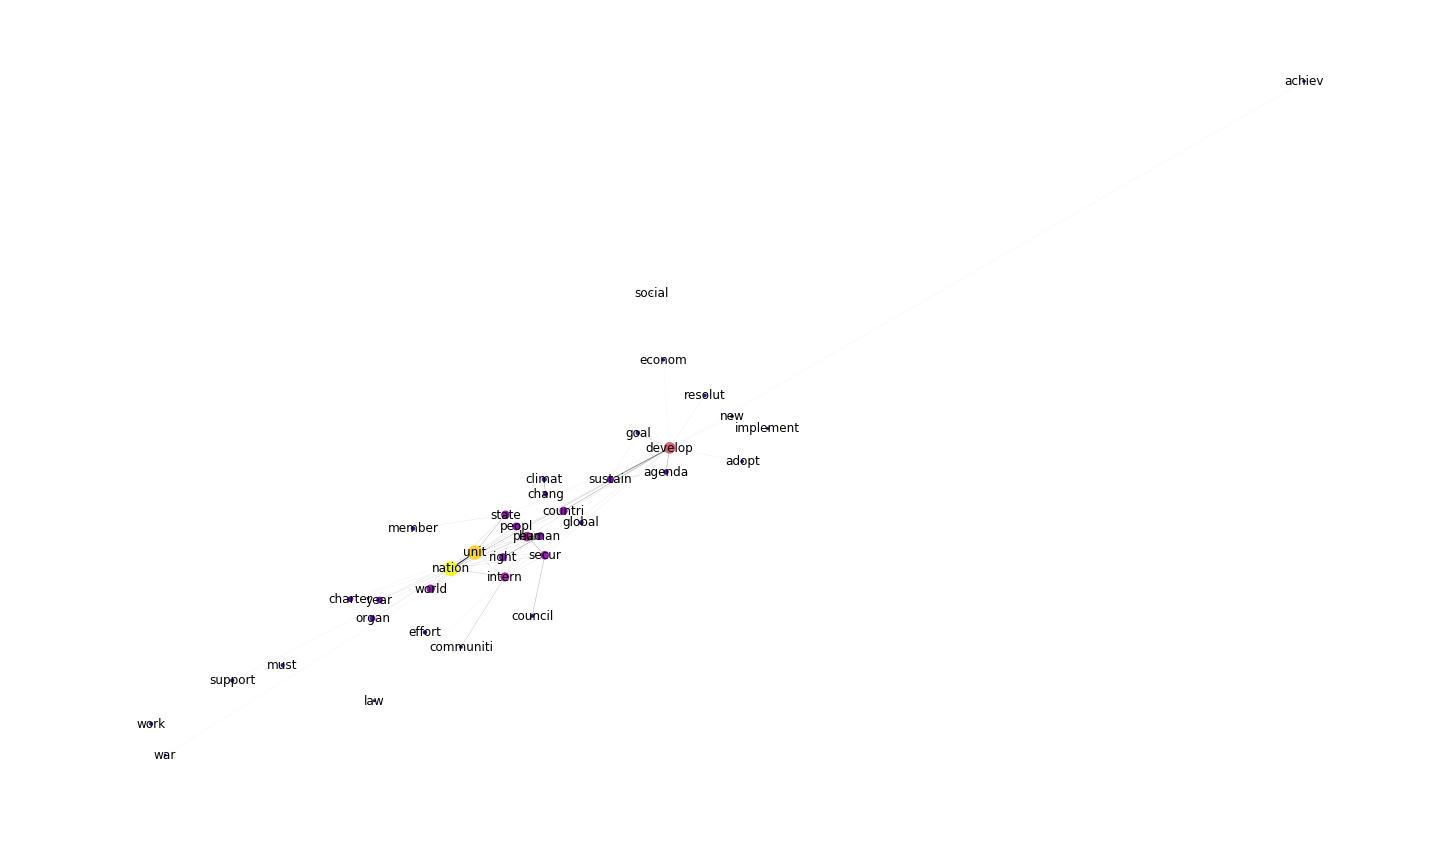

In [190]:
fig, ax = plt.subplots(figsize = (25,15))
maxC = max(centralities.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in giant.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in giant.edges(data = True)))
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in giant.edges(data = True)], 
        alpha = .9, 
        node_color = [centralities[n] / maxC for n in giant.nodes()],
        node_size = [centralities[n] / maxC * 200 for n in giant.nodes()],
        cmap = plt.get_cmap('plasma')) 

Note how the colors reveal a much more graduate distribution here. Let's look at it directly.

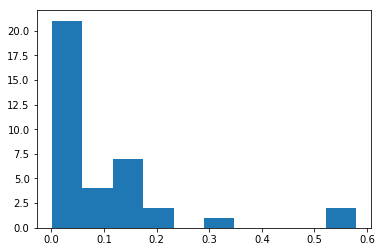

In [191]:
plt.hist(list(centralities.values()))
plt.show()

Top and bottom:

In [192]:
sorted(centralities.items(), key = lambda x: x[1], reverse = True)[:10]

[('nation', 0.579172188519298),
 ('unit', 0.5243974005675908),
 ('develop', 0.32329741262911343),
 ('peac', 0.21416273986852244),
 ('intern', 0.1884565433213814),
 ('secur', 0.1673850343124954),
 ('state', 0.16139285373350123),
 ('world', 0.1579474820686046),
 ('countri', 0.15029365466491426),
 ('right', 0.13767121780719235)]

In [193]:
sorted(centralities.items(), key = lambda x: x[1], reverse = True)[-10:]

[('communiti', 0.0208091154476427),
 ('new', 0.02015906135427886),
 ('resolut', 0.02015906135427886),
 ('adopt', 0.02015906135427886),
 ('achiev', 0.01805915912987481),
 ('econom', 0.016972975881653172),
 ('implement', 0.014139341644320588),
 ('law', 0.009629316167928781),
 ('war', 0.00868596401671988),
 ('social', 0.000757015271637419)]

We can now filter our network by a centrality measure. Let's define a function and experiment with it:

In [39]:
def filterWords(G, minWeight = 3, filter_ = "betweenness", rule = "number", value_of_rule = 200):
    """Function to filter network by degree centrality measures"""
    G = G.copy()
    try:
        G.remove_edges_from([(n1,n2) for n1, n2, d in G.edges(data = True) if d['weight'] < minWeight])
    except:
        print("weight might be missing from one or more edges")
        raise
    if filter_ =="betweenness":
        index = nx.betweenness_centrality(G) #betweeness centrality score
    elif filter_ == "closeness":
        index = nx.closeness_centrality(G) #closeness centrality score
    elif filter_ == "eigenvector":
        index = nx.eigenvector_centrality(G) #eigenvector centrality score
    elif filter_ == "degree":
        index = nx.degree_centrality(G) #degree centrality score
    else:
        raise ValueError("wrong filter paremeter, should be: betweenness/closeness/eigenvector")    
        
    if rule=='number':# if filter by limiting the total number of nodes 
        
        sorted_index = sorted(index.items(), key=lambda x:x[1], reverse=True)
        value_of_rule = np.min([value_of_rule, len(G.nodes())])
        
        nodes_remain = {}
        for word, centr in sorted_index[:value_of_rule]:
            nodes_remain[word] = centr
        G.remove_nodes_from([n for n in index if n not in nodes_remain])
        print ("Total number of nodes(after filtering) in the graph is %s" % len(G))
        return G
    
    if rule=='above':# if filter by limiting the min value of centrality
        value_of_rule = np.max([float(value_of_rule),0])
        G.remove_nodes_from([n for n in index if index[n] >=value_of_rule])
        print ("Total number of nodes(after filtering) in the graph is %s" % len(G))
        return G
    
    if rule=='below':# if filter by limiting the max value of centrality
        value_of_rule = np.max([float(value_of_rule),0])
        G.remove_nodes_from([n for n in index if index[n] <=value_of_rule])
        print ("Total number of nodes(after filtering) in the graph is %s" % len(G))
        return G

In [197]:
giant_filtered30 = filterWords(giant, minWeight=3, filter_='betweenness', rule='number', value_of_rule=25)
print(nx.info(giant_filtered30))

Total number of nodes(after filtering) in the graph is 25
Name: ()
Type: Graph
Number of nodes: 25
Number of edges: 76
Average degree:   6.0800


/Users/arvindilamaran/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  draw_networkx(G, pos=pos, ax=ax, **kwds)
/Users/arvindilamaran/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:522: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  
/Users/arvindilamaran/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:543: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  raise ImportError("Matplotlib required for draw()")
/Users/arvindilamaran/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:724: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  
/Users/arvindilamaran/anaconda3/lib/python3.6/si

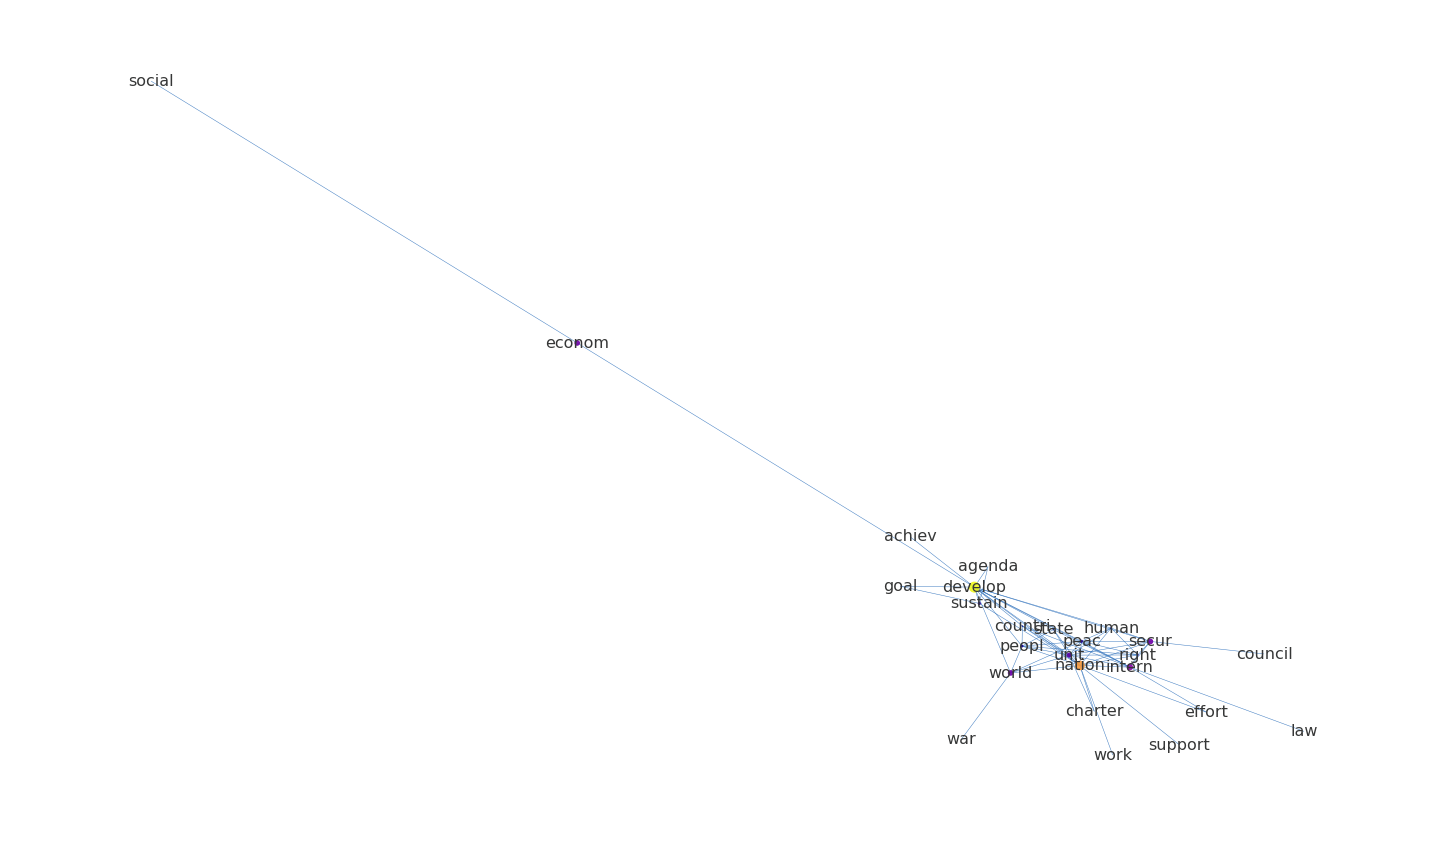

In [199]:
layout_giant_filtered30 = nx.spring_layout(giant_filtered30, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (25,15))
centralities_giant30 = nx.betweenness_centrality(giant_filtered30)
maxC = max(centralities_giant30.items(), key = lambda x : x[1])[1]
nx.draw(giant_filtered30, ax = ax, pos = layout_giant_filtered30, labels = {n: n for n in giant_filtered30.nodes()},
        alpha = .9, 
        width = .5,
        node_color = [centralities_giant30[n] / maxC for n in giant_filtered30.nodes()],
        node_size = [centralities_giant30[n] / maxC * 100 for n in giant_filtered30.nodes()],
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:medium blue',
        cmap = plt.get_cmap('plasma'),
       )

We can also look at global statistics, like the density of a network, defined as the number of actual edges divided by the total number of possible edges:

In [200]:
nx.density(giant)

0.14414414414414414

We can also calculate the average degree per node:

In [235]:
tf = pandas.DataFrame.from_dict(nx.degree(giant),orient='index')
tf.columns=['degree']
pandas.DataFrame.mean(tf['degree'])

5.1891891891891895

The diameter calculates the average distance between any two nodes in the network:

In [203]:
nx.diameter(giant)

4

# POS based networks

Now let's look at links between specific parts of speech within a network.

For this we will be using the `nltk` POS facilities instead of the Stanford ones. These are much faster, but also somewhat less accurate. (You get what you *pay* for in computational power).

Let's look at nouns co-occurring in sentences using the top 10 (by score) reddit posts on thread topics we have explored in prior sessions:

In [3]:
redditDF = pandas.read_csv('../DATA/un-general-debates.csv', index_col = 0)

In [4]:
redditTopScores = redditDF.sort_values('year')[-100:]
redditTopScores['sentences'] = redditTopScores['text'].apply(lambda x: [nltk.word_tokenize(s) for s in nltk.sent_tokenize(x)])
redditTopScores.index = range(len(redditTopScores) - 1, -1,-1) #Reindex to make things nice in the future
redditTopScores[:3]

,year,country,text,sentences
99,2015,SYR,I would like to congratulate Mr. Mogens Lykket...,"[[I, would, like, to, congratulate, Mr., Mogen..."
98,2015,TUV,On behalf of the Government and the people of ...,"[[On, behalf, of, the, Government, and, the, p..."
97,2015,LIE,"It is an honour to be back in the Assembly, es...","[[It, is, an, honour, to, be, back, in, the, A..."


Now we'll normalize the tokens through stemming:

In [5]:
redditTopScores['normalized_sents'] = redditTopScores['sentences'].apply(lambda x: [lucem_illud.normalizeTokens(s, stopwordLst = None, stemmer = lucem_illud.stemmer_basic) for s in x])

In [6]:
def posCooccurrence(sentences, *posType, makeMatrix = False):
    words = set()
    wMap = list()
    reducedSents = []
    #Only using the first kind of POS for each word
    wordsMap = {}
    for sent in sentences:
        s = [(w, t) for w, t in nltk.pos_tag(sent) if t in posType]
        for w, t in s:
            if w not in wordsMap:
                wordsMap[w] = t
        reducedSent = [w for w, t in s]
        words |= set(reducedSent)
        reducedSents.append(reducedSent)
    wordLst = list(words)
    wordIndices = {w: i for i, w in enumerate(wordLst)}
    wordCoCounts = {}
    #consider a sparse matrix if memory becomes an issue
    coOcMat = np.zeros((len(wordIndices), len(wordIndices)))
    for sent in reducedSents:
        for i, word1 in enumerate(sent):
            word1Index = wordIndices[word1]
            for word2 in sent[i + 1:]:
                coOcMat[word1Index][wordIndices[word2]] += 1
    if makeMatrix:
        return coOcMat, wordLst
    else:
        coOcMat = coOcMat.T + coOcMat
        g = nx.convert_matrix.from_numpy_matrix(coOcMat)
        g = nx.relabel_nodes(g, {i : w for i, w in enumerate(wordLst)})
        for w in g.nodes():
            g.node[w]['bipartite'] = wordsMap[w]
        return g

In [64]:
def wordmaps(sentences,*posType):
    words = set()
    reducedSents = []
    #Only using the first kind of POS for each word
    wordsMap = {}
    for sent in sentences:
        s = [(w, t) for w, t in nltk.pos_tag(sent) if t in posType]
        for w, t in s:
             if w not in wordsMap:
                    wordsMap[w] = t
        reducedSent = [w for w, t in s]
        words |= set(reducedSent)
        reducedSents.append(reducedSent)
    wordLst = list(words)
    return wordsMap

In [65]:
%%time
def customPOS(sentences, *posType):
    wordsMap = wordmaps(sentences,posType)
    g = posCooccurrence(sentences,posType)
    for w in g.nodes():
        g.node[w]['bipartite'] = wordsMap[w]
    return g

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 8.11 µs


In [7]:
gNN = posCooccurrence(redditTopScores['normalized_sents'].sum(),'NN')

In [8]:
nx.get_node_attributes(gNN,'bipartite')

{'turnov': 'NN',
 'spiritu': 'NN',
 'innat': 'NN',
 'oversea': 'NN',
 'object': 'NN',
 'sawab': 'NN',
 'marvel': 'NN',
 'standbi': 'NN',
 'orlando': 'NN',
 'somali': 'NN',
 'aceh': 'NN',
 'incur': 'NN',
 'blade': 'NN',
 'dure': 'NN',
 'generat': 'NN',
 'durabl': 'NN',
 'counter': 'NN',
 'denunci': 'NN',
 'dubrovnik': 'NN',
 'format': 'NN',
 'outrag': 'NN',
 'remark': 'NN',
 'pincer': 'NN',
 'wholeheart': 'NN',
 'srebrenica': 'NN',
 'jinp': 'NN',
 'hegemoni': 'NN',
 'despit': 'NN',
 'impair': 'NN',
 'assumpt': 'NN',
 'scarc': 'NN',
 'houthi': 'NN',
 'embrac': 'NN',
 'trusteeship': 'NN',
 'wood': 'NN',
 'melt': 'NN',
 'modern': 'NN',
 'regener': 'NN',
 'pragmat': 'NN',
 'fight': 'NN',
 'angl': 'NN',
 'benin': 'NN',
 'abadi': 'NN',
 'predat': 'NN',
 'censorship': 'NN',
 'enthusiast': 'NN',
 'luxembourg': 'NN',
 'reaction': 'NN',
 'scratch': 'NN',
 'occup': 'NN',
 'sport': 'NN',
 'moro': 'NN',
 'proud': 'NN',
 'anniversari': 'NN',
 'setback': 'NN',
 'nostalgia': 'NN',
 'crise': 'NN',
 'goo

In [9]:
print(nx.info(gNN))

Name: 
Type: Graph
Number of nodes: 4505
Number of edges: 150966
Average degree:  67.0215


This is a bit too large to effectively visualize, so let's remove the vertices with degree less than or equal to 200:

In [10]:
gNN.remove_nodes_from([n for n in gNN.nodes() if len(set(gNN.neighbors(n))) <= 400]) 
print(nx.info(gNN))

Name: 
Type: Graph
Number of nodes: 126
Number of edges: 7069
Average degree: 112.2063


And low weight edges:

In [11]:
gNN.remove_edges_from([(n1, n2) for n1, n2, d in gNN.edges(data = True) if d['weight'] <= 80])
print(nx.info(gNN))

Name: 
Type: Graph
Number of nodes: 126
Number of edges: 72
Average degree:   1.1429


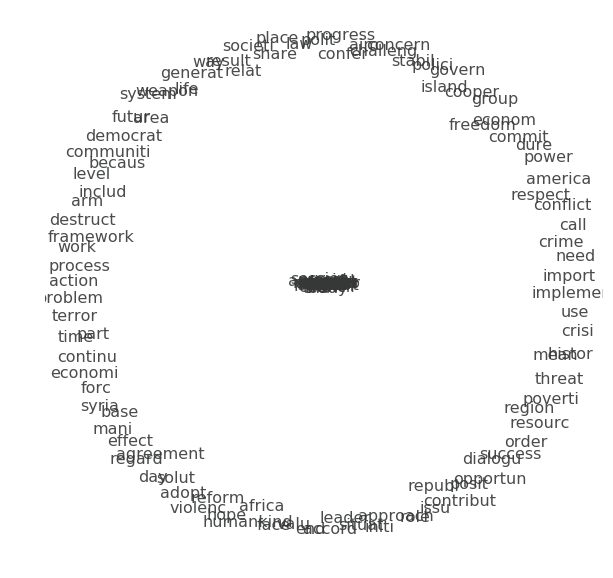

In [12]:
layout_nn = nx.spring_layout(gNN, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
centralities_nn = nx.eigenvector_centrality(gNN)
maxC = max(centralities_nn.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in gNN.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in gNN.edges(data = True)))
nx.draw(gNN, ax = ax, pos = layout_nn, labels = {n: n for n in gNN.nodes()},
        #width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in gNN.edges(data = True)], 
        alpha = .9, 
        node_color = [centralities_nn[n] / maxC for n in gNN.nodes()],
        node_size = [centralities_nn[n] / maxC * 100 for n in gNN.nodes()],
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:medium blue',
        cmap = plt.get_cmap('plasma'),
       )

In [14]:
gNV = posCooccurrence(redditTopScores['normalized_sents'].sum(), 'NN', 'VB')

gNV has co-occurrences between nouns and nouns as well as between verbs and verbs. Let's remove these and make it purely about noun and verb combinations:

In [16]:
gNV.remove_edges_from([(n1,n2) for n1,n2,d in gNV.edges(data = True) if gNV.nodes[n1]['bipartite'] == gNV.nodes[n2]['bipartite']])

In [17]:
print(nx.info(gNV))

Name: 
Type: Graph
Number of nodes: 4818
Number of edges: 49884
Average degree:  20.7073


Dropping low weight edges and low degree vertices gives us:

In [21]:
gNV.remove_edges_from([(n1, n2) for n1, n2, d in gNV.edges(data = True) if d['weight'] <= 8])
gNV.remove_nodes_from([n for n in gNV.nodes if len(set(gNV.neighbors(n))) <= 5])

In [22]:
print(nx.info(gNV))

Name: 
Type: Graph
Number of nodes: 76
Number of edges: 503
Average degree:  13.2368


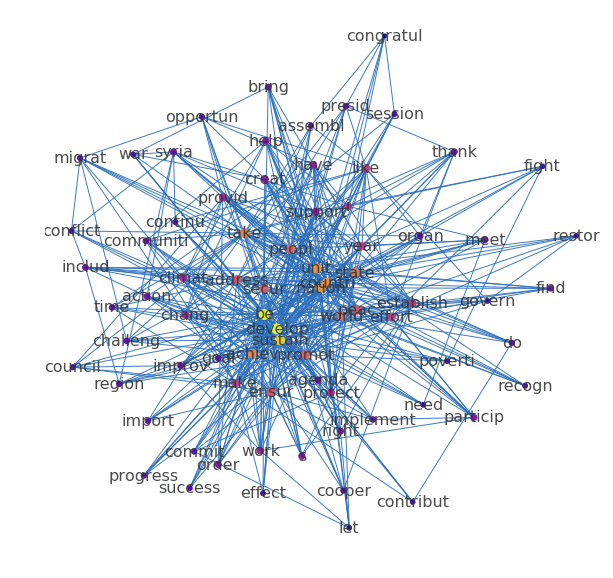

In [23]:
Lets create an "ego network" surrounding a single (important) word, as we did before:

g_i = gNV.subgraph(['i'] + list(gNV.neighbors('i')))

print(nx.info(g_i))

nx.draw_networkx(g_i)

Instead of just nodes connected to a vertex, we can find all those connected to it within 2 hops, lets look at 'stori' for this:

storyNeighbors = gNV.neighbors('stori')
set(storyNeighbors)

storyNeighbors = set(gNV.neighbors('stori'))
storyNeighborsPlus1 = set(storyNeighbors)
for n in storyNeighbors:
    storyNeighborsPlus1 |= set(gNV.neighbors(n))

gNV_story = gNV.subgraph(storyNeighborsPlus1)
print(nx.info(gNV_story))

This is a mid-sized network, but we can interrogate it intelligently by computing some statistics. Degree centrality:

sorted(nx.degree_centrality(gNV_story).items(), key = lambda x: x[1], reverse = True)[:10]

Or eigenvector centrality:

sorted(nx.eigenvector_centrality(gNV_story).items(), key = lambda x: x[1], reverse = True)[:10]

Notice that 'stori' isn't even in the top 5:

Lets plot it:

layout_story = nx.spring_layout(gNV_story, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
nx.draw(gNV_story, ax = ax, pos = layout_story, labels = {n: n for n in gNV_story.nodes()},
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:medium blue',
       ) 

"I" is still in the middle. These are stories about the self.

Lets create a noun-adjective network:

gNJ = posCooccurrence(redditTopScores['normalized_sents'][:100].sum(), 'NN', 'JJ')
print(nx.info(gNJ))

By filtering by a centrality measure we can get a more 'central' set of nodes instead of just the most connected.

gNJ_filtered200 = filterWords(gNJ, minWeight=3, filter_='betweenness', rule='number', value_of_rule=25)
print(nx.info(gNJ_filtered200))

layout_NJ_filtered200 = nx.spring_layout(gNJ_filtered200, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
centralities_nj200 = nx.betweenness_centrality(gNJ_filtered200)
maxC = max(centralities_nj200.items(), key = lambda x : x[1])[1]
nx.draw(gNJ_filtered200, ax = ax, pos = layout_NJ_filtered200, labels = {n: n for n in gNJ_filtered200.nodes()},
        alpha = .9, 
        width = .5,
        node_color = [centralities_nj200[n] / maxC for n in gNJ_filtered200.nodes],
        node_size = [centralities_nj200[n] / maxC * 100 for n in gNJ_filtered200.nodes],
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:medium blue',
        cmap = plt.get_cmap('plasma'),
       )

A truly self-centered network.layout_nn = nx.spring_layout(gNV, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
centralities_nv = nx.eigenvector_centrality(gNV)
maxC = max(centralities_nv.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in gNV.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in gNV.edges(data = True)))
nx.draw(gNV, ax = ax, pos = layout_nn, labels = {n: n for n in gNV.nodes()},
        #width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in gNN.edges(data = True)], 
        alpha = .9, 
        node_color = [centralities_nv[n] / maxC for n in gNV.nodes],
        node_size = [centralities_nv[n] / maxC * 100 for n in gNV.nodes],
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:medium blue',
        cmap = plt.get_cmap('plasma'),
       ) 

Lets create an "ego network" surrounding a single (important) word, `syria`, as we did before:

In [27]:
g_i = gNV.subgraph(['climat'] + list(gNV.neighbors('climat')))

In [28]:
print(nx.info(g_i))

Name: 
Type: SubGraph
Number of nodes: 14
Number of edges: 13
Average degree:   1.8571


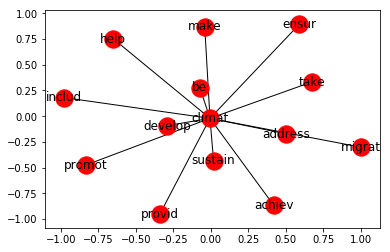

In [29]:
nx.draw_networkx(g_i)

In the graph, we see that `climate` is linked to development, sustainability and even migration. But we are note sure, if this is an ego-centric network. 

Instead of just nodes connected to a vertex, we can find all those connected to it within 2 hops, lets look at 'stori' for this:

In [30]:
storyNeighbors = gNV.neighbors('climat')
set(storyNeighbors)

{'achiev',
 'address',
 'be',
 'develop',
 'ensur',
 'help',
 'includ',
 'make',
 'migrat',
 'promot',
 'provid',
 'sustain',
 'take'}

In [31]:
storyNeighbors = set(gNV.neighbors('climat'))
storyNeighborsPlus1 = set(storyNeighbors)
for n in storyNeighbors:
    storyNeighborsPlus1 |= set(gNV.neighbors(n))

In [32]:
gNV_story = gNV.subgraph(storyNeighborsPlus1)
print(nx.info(gNV_story))

Name: 
Type: SubGraph
Number of nodes: 58
Number of edges: 322
Average degree:  11.1034


This is a mid-sized network, but we can interrogate it intelligently by computing some statistics. Degree centrality:

In [33]:
sorted(nx.degree_centrality(gNV_story).items(), key = lambda x: x[1], reverse = True)[:10]

[('be', 0.7894736842105263),
 ('develop', 0.7894736842105263),
 ('sustain', 0.7017543859649122),
 ('take', 0.5087719298245614),
 ('achiev', 0.49122807017543857),
 ('promot', 0.43859649122807015),
 ('ensur', 0.42105263157894735),
 ('address', 0.38596491228070173),
 ('make', 0.3508771929824561),
 ('provid', 0.24561403508771928)]

Or eigenvector centrality:

In [34]:
sorted(nx.eigenvector_centrality(gNV_story).items(), key = lambda x: x[1], reverse = True)[:10]

[('be', 0.29582379858367097),
 ('develop', 0.29582379858367097),
 ('sustain', 0.27477832271934066),
 ('achiev', 0.2144906294936094),
 ('take', 0.2090941792484239),
 ('promot', 0.18610159914238933),
 ('ensur', 0.18473044271815964),
 ('address', 0.17381799825807542),
 ('countri', 0.1540316299941719),
 ('chang', 0.1540316299941719)]

Notice that 'climat' isn't even in the top 5:

Lets plot it:

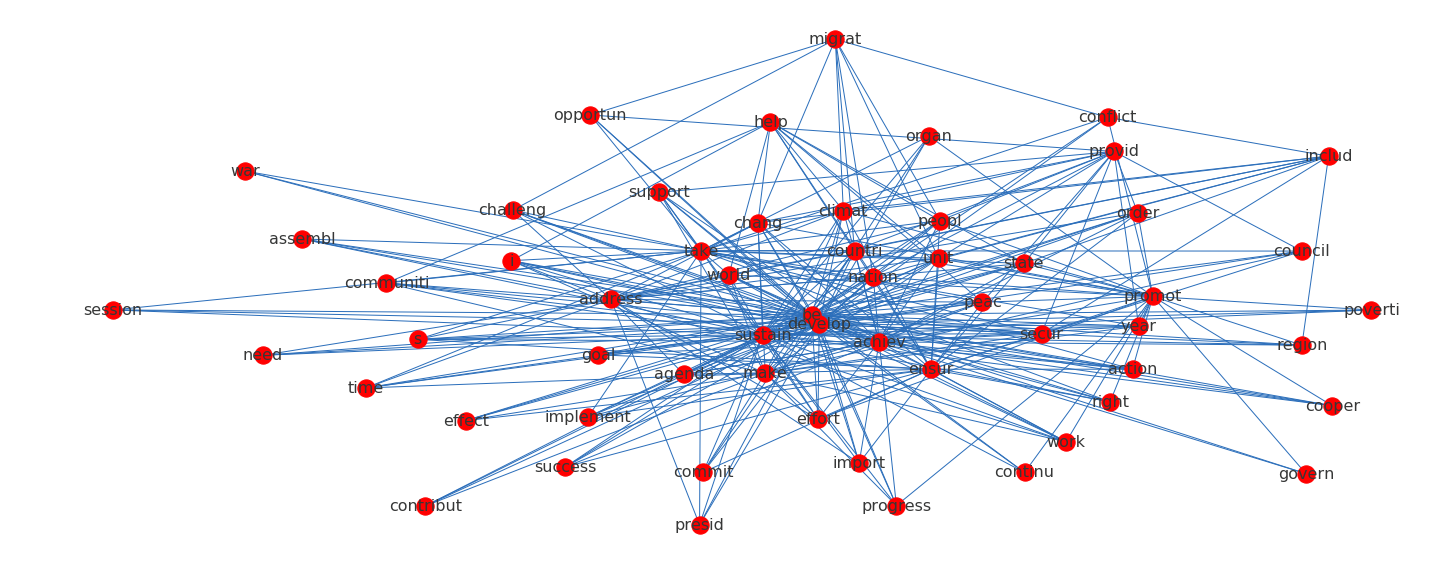

In [36]:
layout_story = nx.spring_layout(gNV_story, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (25,10))
nx.draw(gNV_story, ax = ax, pos = layout_story, labels = {n: n for n in gNV_story.nodes()},
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:medium blue',
       ) 

'climat' is not in the middle. This could mean that much of the text in the United Nations general debate were not centered around `climate change` but as an issue discussed in tandem with other issues.

Lets create a noun-adjective network:

In [37]:
gNJ = posCooccurrence(redditTopScores['normalized_sents'][:100].sum(), 'NN', 'JJ')
print(nx.info(gNJ))

Name: 
Type: Graph
Number of nodes: 5318
Number of edges: 248436
Average degree:  93.4321


By filtering by a centrality measure we can get a more 'central' set of nodes instead of just the most connected.

In [40]:
gNJ_filtered200 = filterWords(gNJ, minWeight=3, filter_='betweenness', rule='number', value_of_rule=25)
print(nx.info(gNJ_filtered200))

Total number of nodes(after filtering) in the graph is 25
Name: 
Type: Graph
Number of nodes: 25
Number of edges: 314
Average degree:  25.1200


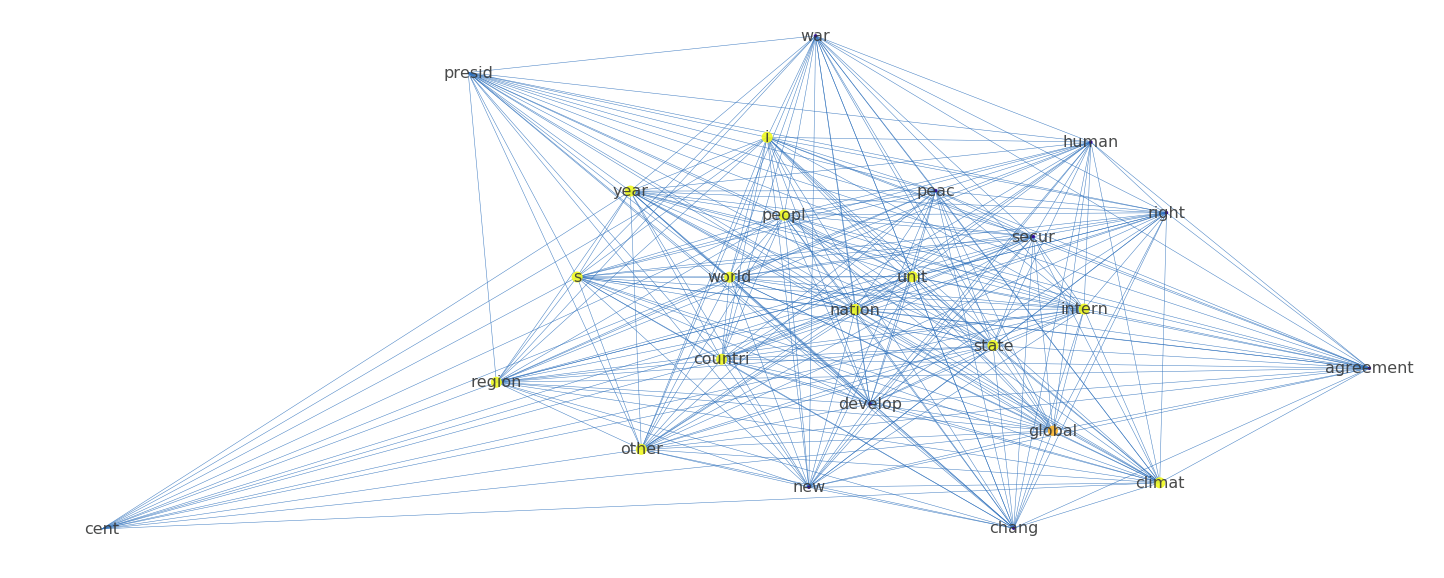

In [42]:
layout_NJ_filtered200 = nx.spring_layout(gNJ_filtered200, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (25,10))
centralities_nj200 = nx.betweenness_centrality(gNJ_filtered200)
maxC = max(centralities_nj200.items(), key = lambda x : x[1])[1]
nx.draw(gNJ_filtered200, ax = ax, pos = layout_NJ_filtered200, labels = {n: n for n in gNJ_filtered200.nodes()},
        alpha = .9, 
        width = .5,
        node_color = [centralities_nj200[n] / maxC for n in gNJ_filtered200.nodes],
        node_size = [centralities_nj200[n] / maxC * 100 for n in gNJ_filtered200.nodes],
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:medium blue',
        cmap = plt.get_cmap('plasma'),
       )

This is definitely not a self-centered network. But on further explorations, such data might come up.

# Interactional influence

In a recent paper by Fangjian Guo, Charles Blundell, Hanna Wallach, and Katherine Heller entitled ["The Bayesian Echo Chamber: Modeling Social Influence via Linguistic Accommodation"](https://arxiv.org/pdf/1411.2674.pdf), the authors develop a method to estimate the influence of one speaker on another in order to estimate a kind of interpersonal influence network. Here we walk through this method, which relies on a kind of point process called a Hawkes process that estimate the influence of one point on another. Specifically, what they estimate is the degree to which one actor to an interpersonal interaction engaged in "accomodation" behaviors relative to the other, generating a directed edge from the one to the other.

In [53]:
senReleasesDF = pandas.read_csv('../DATA/un-general-debates.csv')
senReleasesDF = senReleasesDF.loc[senReleasesDF['country'].isin(['USA','RUS','IND','PAK'])]

In [54]:
senReleasesDF[:3]

,session,year,country,text
7,44,1989,RUS,﻿My task as head of the delegation of the Sovi...
100,44,1989,PAK,"﻿It gives me great pleasure, Sir, to offer you..."
115,44,1989,IND,﻿\nMy delegation warmly welcomes the assumptio...


In [55]:
from nltk.tokenize import RegexpTokenizer
#tokenizer = RegexpTokenizer(r'\w+')
tokenizer = RegexpTokenizer('[a-zA-Z]\w+\'?\w*')
senReleasesDF['tokenized_words'] = senReleasesDF['text'].apply(lambda x: tokenizer.tokenize(x))
senReleasesDF['tokens'] = senReleasesDF['tokenized_words']

In [56]:
senReleasesDF['country_code'] = senReleasesDF['country'].map({'USA': 1, 'RUS': 2, 'IND': 3, 'PAK':4})

In [57]:
senReleasesDF['start'] = pandas.to_numeric(senReleasesDF['year']) + senReleasesDF['country_code']/10
senReleasesDF['end'] = pandas.to_numeric(senReleasesDF['year']) + senReleasesDF['country_code']/10 + 0.5

In [58]:
senReleasesDF = senReleasesDF.sort_values('year')
senReleasesDF['name'] = senReleasesDF['country']


In [60]:
data = senReleasesDF.filter(regex=('name|tokens|start|end'))

In [62]:
df_transcript = data

Transform data into TalkbankXML format:

In [68]:
import subprocess

def make_TalkbankXML(df, fname, database='my_dataset',language='eng'):
    '''
    This function will transform pandas dataframe into TalkbankXML for Bayesian estimation of influence.
    df:  pandas dataframe of utterences, need four columns: "name", "tokens", "start", "end".
    ("start", "end" is the start_time, and end_time of a utterence)
    fname:  file name to save xml output
    database: (arbitrary) name of your database
    language: 'eng' is the default. (currently also support 'chinese')
    Important: All non-English tokens and names should be unicode.
    '''


    #format dataframe
    df = df[['name','tokens','start','end']]
    unit='s'
    df['start'] = df['start'].apply(pandas.to_numeric)
    df['end'] = df['end'].apply(pandas.to_numeric)
    df = df.dropna() # only allow non-missing data
    df = pandas.DataFrame(sorted(df.values.tolist(),key=lambda x:x[2]),columns=df.columns) #sort by time

    #generate xml
    fname_short = fname
    if os.path.sep in fname:
        new_path = "."+os.path.sep+'data'+os.path.sep+fname.split(os.path.sep)[-1].split('.')[0]+os.path.sep
        fname_short = fname.split(os.path.sep)[-1].split(os.path.sep)[0]
    else:
        new_path = "."+os.path.sep+'data'+os.path.sep+fname.split('.')[0]+os.path.sep
    if not '.' in fname_short:
        fname_short+='.xml'
    else:
        fname_short = fname_short.split('.')[0]+'.xml'
    if not os.path.exists(new_path):
        os.makedirs(new_path)

    with open(new_path+fname_short,'w') as fw:
        print ('<?xml version="1.0" encoding="UTF-8"?>\n',file=fw)
        print ('<CHAT from="%s">' % database,file=fw)

        #create person_ids
        person_id ={}
        for person in set(df['name'].values.tolist()):
            if not person in person_id: person_id[person] = len(person_id)+1

        #add participants
        print ('<Participants>',file=fw)
        for person in person_id:
            print ('<participant id="%s" name="%s" role="Adult" language="%s"/>' %(person,person,language),file=fw)
        print ('</Participants>\n',file=fw)

        #add utterences
        for row in df.values:
            print ('<u who="%s" uID="#%s">' % (row[0],person_id[row[0]]),file=fw)
            for word in row[1]:
                print ('''<w>%s</w>''' % word, file=fw)

            print ('''<media start="%s" end="%s" unit="%s"/>''' %(row[2],row[3],unit),file=fw)
            print ('''</u>''',file=fw)
            print ('''''', file=fw)
        print ("</CHAT>\n",file=fw)


    print ('New File saved to %s' % new_path+fname_short)
    return 0


def bec_run(output_fname, Vocab_size, language, sampling_time):
    subprocess.call(["python", "../data/Bayesian-echo/src/run_bec.py", output_fname,str(Vocab_size),language,str(int(sampling_time))])

In [69]:
output_fname = 'UN_US_RUS_IND_PAK.xml'  #should be .xml
language = 'eng' 
#language = 'chinese'
make_TalkbankXML(df_transcript, output_fname, language = language )

New File saved to ./data/UN_US_RUS_IND_PAK/UN_US_RUS_IND_PAK.xml


0

Run Bayesian Echo Chamber to get estimation.

- It may take a couple of hours. ( About 4-5 hours if Vocab_size=600 and sampling_time =2000)
- Larger "Vocab_size" (see below) will cost more time
- Larger "sampling_time" will also consume more time

In [70]:
Vocab_size = 90 # up to Vocab_size most frequent words will be considered, it should be smaller than the total vocab
sampling_time = 1500  #The times of Gibbs sampling sweeps  (500 burn-in not included)
bec_run(output_fname, Vocab_size, language, sampling_time)

I want to parse the UN General Assembly debates of USA, Russia, India and Pakistan from 1970 - 2015. As of 10:54 PM, the code is still running in terminal. 